# Import

In [1]:
import numpy as np
import pandas as pd 
from random import sample
import cv2
from fastai.vision import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import shutil
from glob import glob
%matplotlib inline
import networkx as nx

import networkx as nx
import nxviz
import community
import itertools
import operator

import sys
from PIL import Image

import sys
import os
import numpy as np
from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras

/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understo

# Loading dataset

In [2]:
def open_images_names (directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(im)
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        
        artists.append(art)
        
    return images_all, artists

In [3]:
images, names = open_images_names ("data/resized/resized/**")

## Undersampling por artistas

In [4]:
def rand_under_sampling (df, col_dep):
    
    """
    **************************************************************
    Devuelve el df reducido con RandomUnderSample
    Input:
    *df
    *col_dep: variable dependiente
    **************************************************************
    
    """
    from imblearn.under_sampling import RandomUnderSampler
    
    X = df.drop(col_dep, axis = 1)
    y = df[col_dep]
    
    rus = RandomUnderSampler()
    X_res, y_res = rus.fit_sample(X, y)
    
    df_temp = pd.DataFrame(X_res, columns = X.columns)
    df_temp[col_dep] = y_res
    
    return df_temp

In [5]:
df = pd.DataFrame(images, columns = ['images'])

In [6]:
df['artist'] = names

In [7]:
le = LabelEncoder()
df['code'] = le.fit_transform(df['artist'])

In [8]:
df.head()

,images,artist,code
0,"[[[140, 166, 152], [128, 154, 140], [123, 151,...",Gustav Klimt,20
1,"[[[97, 150, 171], [94, 147, 168], [58, 111, 13...",Vincent van Gogh,48
2,"[[[38, 42, 61], [37, 42, 63], [34, 38, 63], [4...",Amedeo Modigliani,2
3,"[[[71, 69, 68], [68, 66, 65], [70, 66, 65], [6...",Edgar Degas,11
4,"[[[72, 75, 73], [74, 75, 73], [84, 83, 79], [7...",Edgar Degas,11


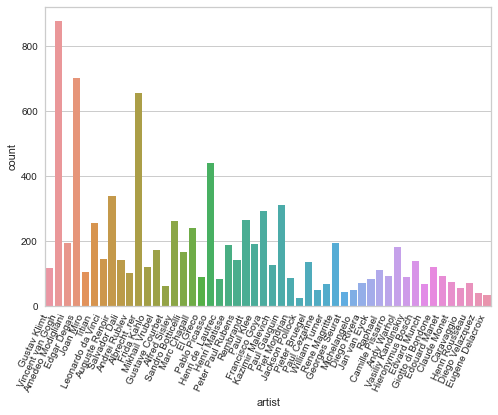

In [9]:
artists_plot = sns.countplot(df['artist'])
_ = artists_plot.set_xticklabels(artists_plot.get_xticklabels(), rotation=65, horizontalalignment='right')

In [10]:
df_under_samp = rand_under_sampling (df, 'artist')

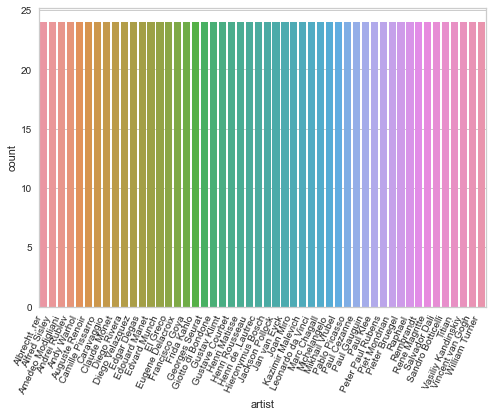

In [14]:
artists_plot = sns.countplot(df_under_samp['artist'])
_ = artists_plot.set_xticklabels(artists_plot.get_xticklabels(), rotation=65, horizontalalignment='right')

In [12]:
df_under_samp.head()

,images,code,artist
0,"[[[233, 233, 233], [237, 237, 237], [237, 237,...",0,"Albrecht ,rer"
1,"[[[195, 216, 218], [191, 212, 214], [188, 207,...",0,"Albrecht ,rer"
2,"[[[191, 191, 191], [173, 173, 173], [190, 190,...",0,"Albrecht ,rer"
3,"[[[219, 219, 219], [223, 223, 223], [229, 229,...",0,"Albrecht ,rer"
4,"[[[179, 179, 179], [169, 169, 169], [169, 169,...",0,"Albrecht ,rer"


In [19]:
artists_dict = {}
for i in range(0, len(df_under_samp['code'])):
    artists_dict[df_under_samp['code'][i]]= df_under_samp['artist'][i]

In [13]:
df_under_samp.to_csv('data/under_samp_artists.csv')

## Separar en train/test

In [15]:
images = np.asarray(df_under_samp['images'])
names = np.asarray(df_under_samp['code'])

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(images, names, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(960,) (960,)
(240,) (240,)


# Preprocess data

In [24]:
# preprocess data

def get_classes(x, y):
    
    indices = []
    
    e = 0.
    for i in range(0, len(y)):
    
        indices_0, _ = np.where(y == e)
        
        indices.append(indices_0)
        e+=1

    indices = np.concatenate(indices, axis=0)
    

    x = np.array(x)[indices.astype(int)]
    y = np.array(y)[indices.astype(int)]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = keras.utils.to_categorical(y)
    
    return x, y

In [31]:
len(Y_train)

960

In [25]:
x_train, y_train = get_classes (X_train, Y_train)
x_test, y_test = get_classes (X_test, Y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

ValueError: not enough values to unpack (expected 2, got 1)

# Visualization helper function

In [ ]:
def label_encoder_out (dic, key):
    return dic.get(int(key))

In [ ]:
def show_random_examples (x, y, p):
    
    indices = np.random.choice (range(x.shape[0]), 10, replace = False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure (figsize = (20, 7))
    for i in range (10):
        plt.subplot (2, 5, 1 + i)
        plt.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(label_encoder_out(artists_dict ,class_names[np.argmax(p[i])]), color=col)
    plt.show

# Visualize examples

In [ ]:
show_random_examples(x_test, y_test, y_train)

# Creating our CNN models

In [ ]:
from keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Input, Dense
from keras.models import Sequential, Model